# Lab 04 - Acquisition functions and Bayesian optimization
## Tasks
- Demonstrate Bayesian optimization
- Solve quadrupole triplet focusing using Bayesian optimization

# Set up environment

In [1]:
%reset -f
!pip install botorch==0.12.0 gpytorch xopt==2.5.2
!pip install cheetah-accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#import packages required for BO
import torch

from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

## GP model creation
We start by generating two random observations to create the initial GP model (using BoTorch this time). Note that BoTorch does a number of things under the hood, including using Normalization and Standardization transformers to normalize and standardize the data.

In [62]:
def f(x):
    return torch.sin(2*torch.pi*x) + x + torch.randn_like(x) * 0.01

train_x = torch.tensor([0.3,0.5],dtype=torch.double).unsqueeze(-1)
train_y = f(train_x)

gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

In [58]:
train_x.shape

torch.Size([2, 1])

### Acquisition function definition
Next we define the acquisition function. For this example we use Log Expected Improvement (EI).

In [63]:
acquisition_function = LogExpectedImprovement(gp, best_f=torch.max(train_y))

### Visualize the GP model and the acquisition function.

Text(0, 0.5, '$\\alpha(x)$')

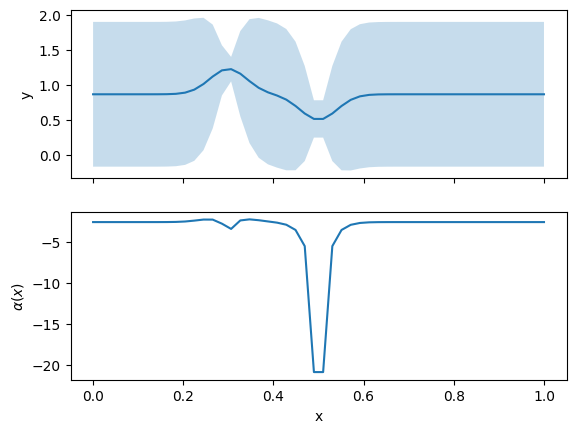

In [64]:
x = torch.linspace(0, 1, 50)
with torch.no_grad():
    p = gp.posterior(x.reshape(-1,1,1))

    #get the mean
    m = p.mean.squeeze()

    #get the 2 sigma confidence region around the mean
    l,u = p.mvn.confidence_region()
    l = l.squeeze()
    u = u.squeeze()

    # calculate the acquisition function
    acqf = acquisition_function(x.reshape(-1,1,1))


fig,ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('x')
ax[0].set_ylabel('y')
#plot mean and confidence region
ax[0].plot(x, m)
ax[0].fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

ax[1].plot(x, acqf)
ax[1].set_ylabel(r"$\alpha(x)$")


### Optimize the acquisition function
Use the `optimize_acqf` function in BoTorch to maximize the acquisition function.

In [83]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)
candidate, acq_value = optimize_acqf(
    acquisition_function, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate

tensor([[1.]], dtype=torch.float64)

In [84]:
bounds

tensor([[0.],
        [1.]], dtype=torch.float64)

# Basic BO
We are going to maximize the following function using Bayesian optimization

$$
f(x) = \sin(2\pi x) + x
$$
in the domain $[0,1]$.

### **Task**
Perform 20 steps of BO to solve the optimization problem. Plot the model and the acquisition function at the end of each optimization step.

In [66]:
def plot_model_acq(gp, xmax, fmax):
  x = torch.linspace(0, 1, 50)
  with torch.no_grad():
      p = gp.posterior(x.reshape(-1,1,1))

      #get the mean
      m = p.mean.squeeze()

      #get the 2 sigma confidence region around the mean
      l,u = p.mvn.confidence_region()
      l = l.squeeze()
      u = u.squeeze()

      # calculate the acquisition function
      acqf = acquisition_function(x.reshape(-1,1,1))


  fig,ax = plt.subplots(2,1,sharex=True)
  ax[1].set_xlabel('x')
  ax[0].set_ylabel('y')
  #plot mean and confidence region
  ax[0].plot(x, m)
  ax[0].plot(xmax, fmax, 'x', color='red', label=f"xmax, fmax=({xmax.item():.3f}, {fmax.item():.3f})")
  ax[0].fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)
  ax[0].legend()
  ax[1].plot(x, acqf)
  ax[1].set_ylabel(r"$\alpha(x)$")

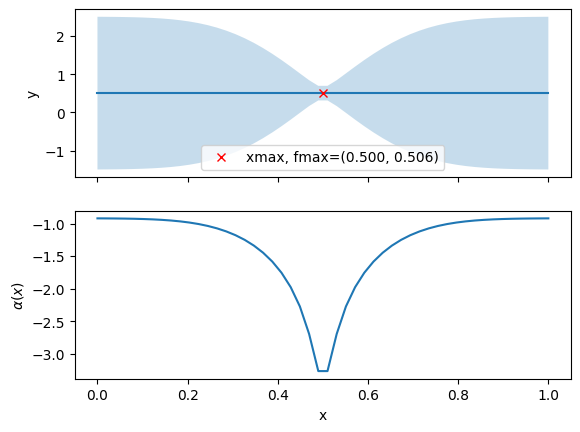

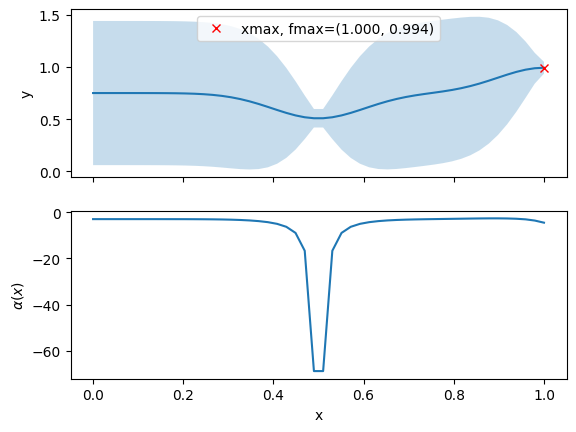

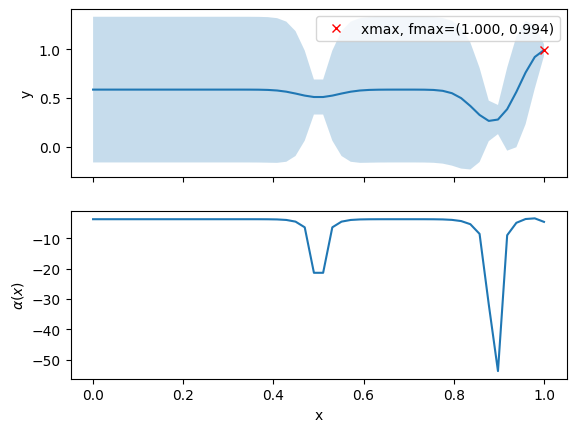

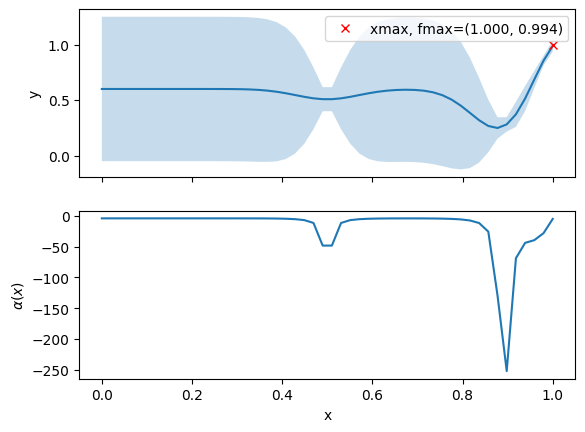

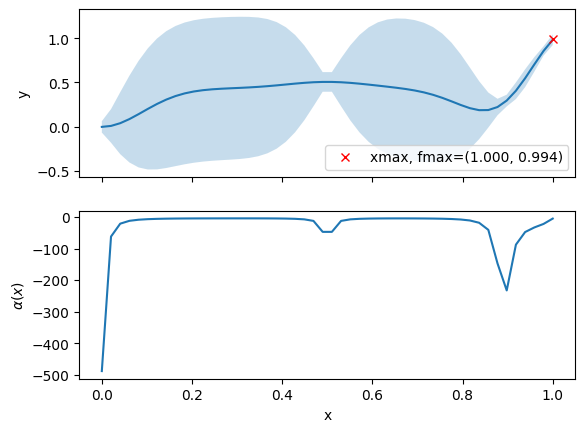

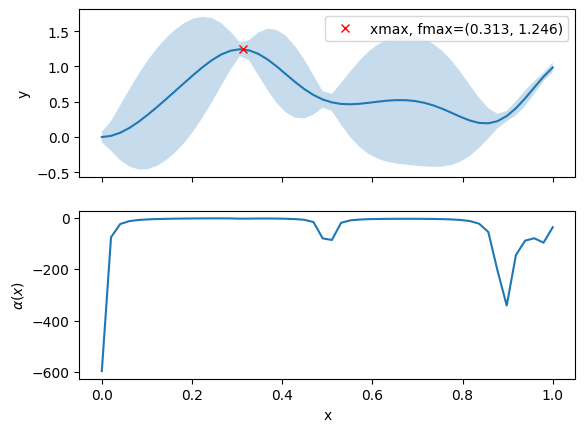

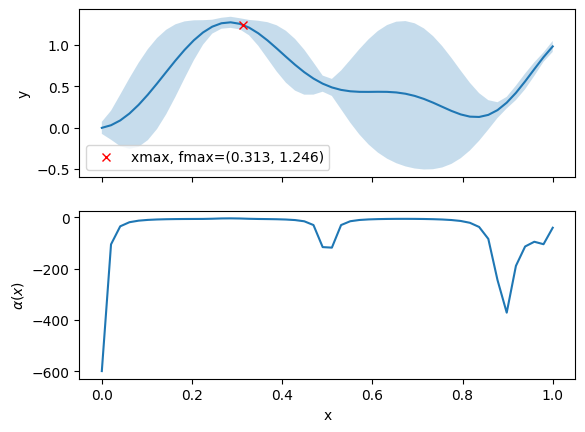

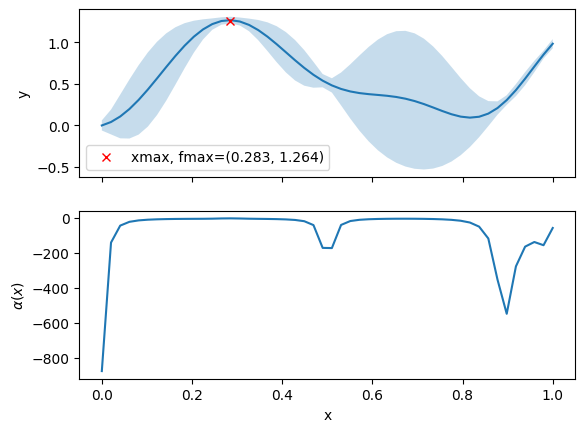

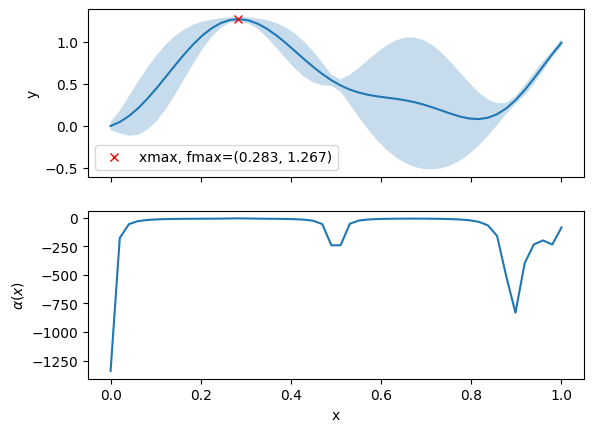

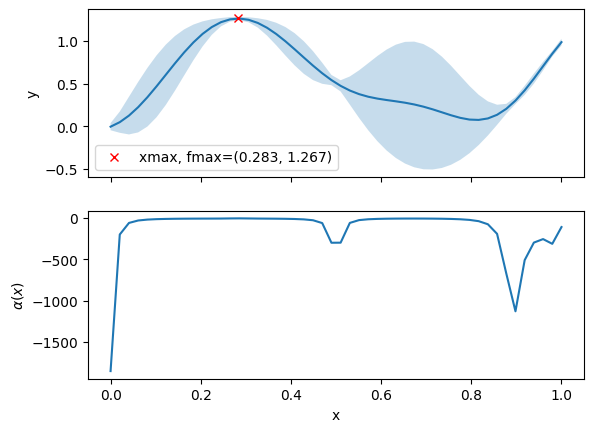

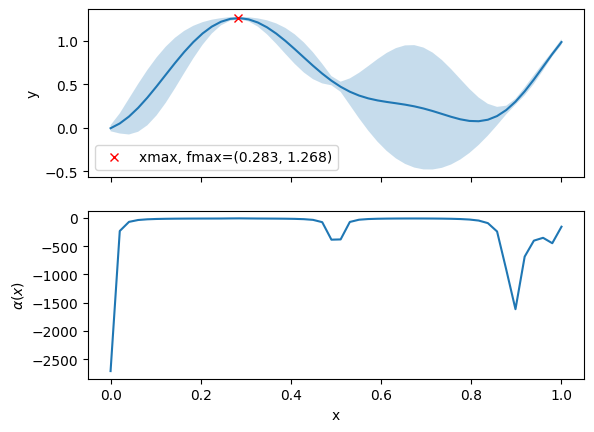

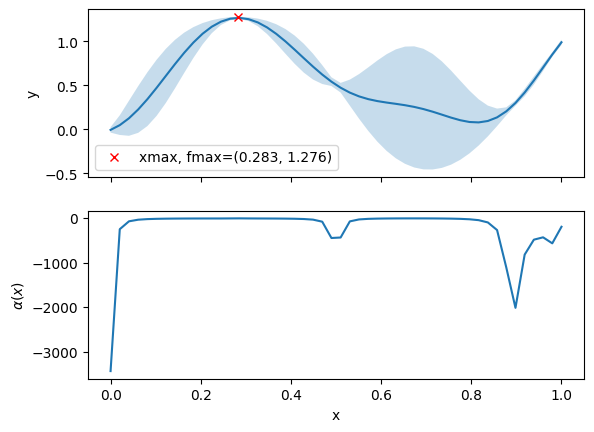

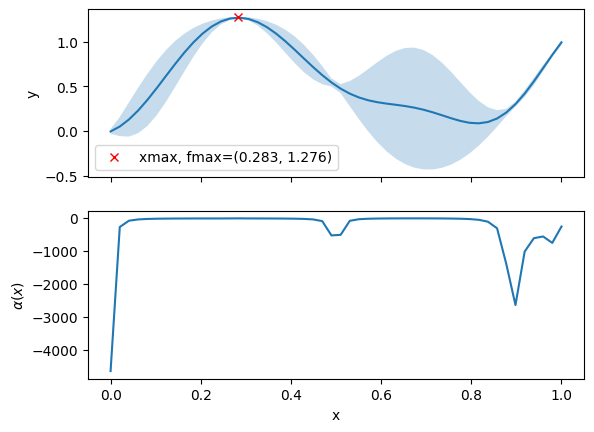

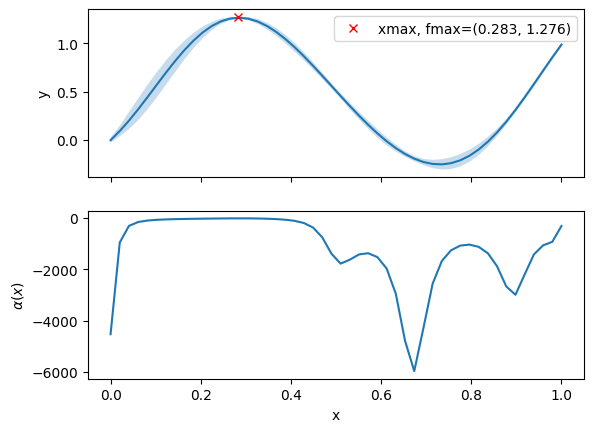

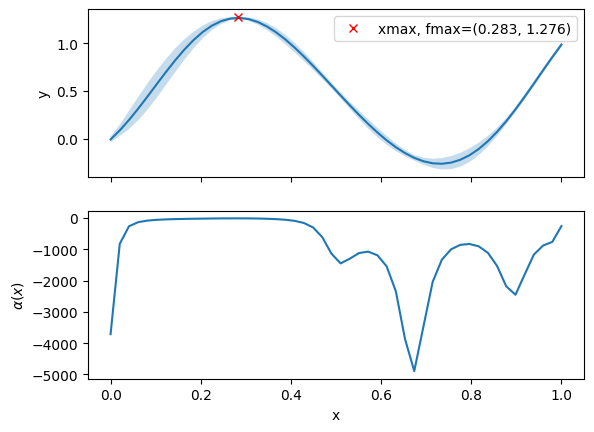

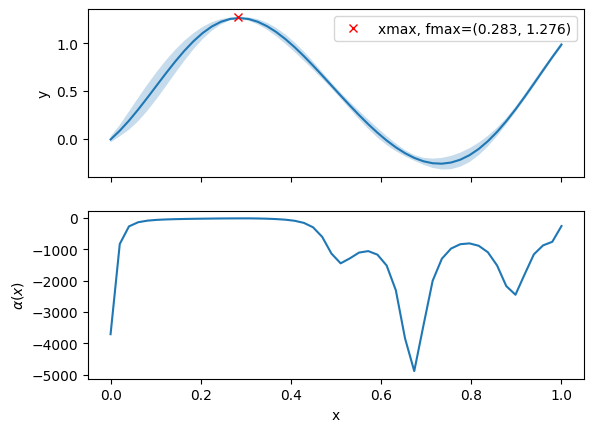

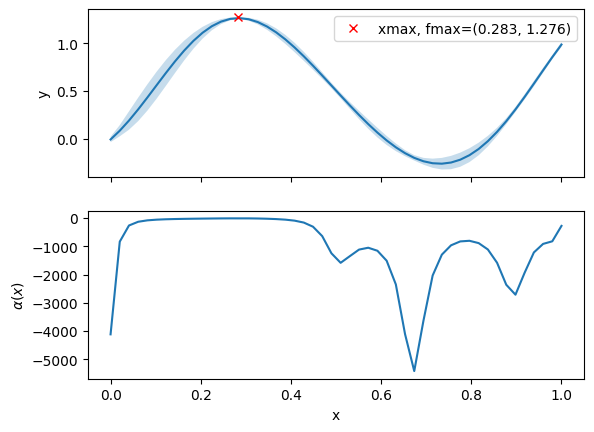

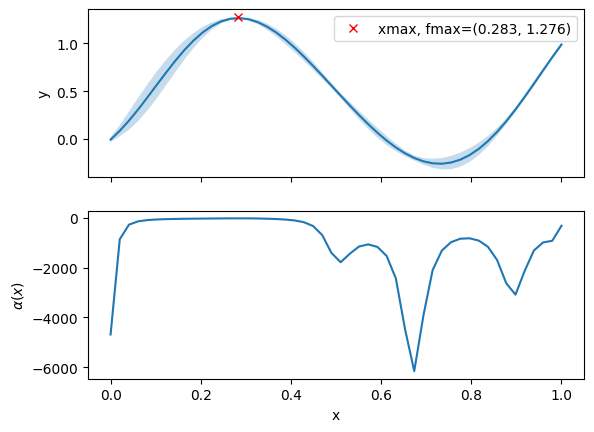

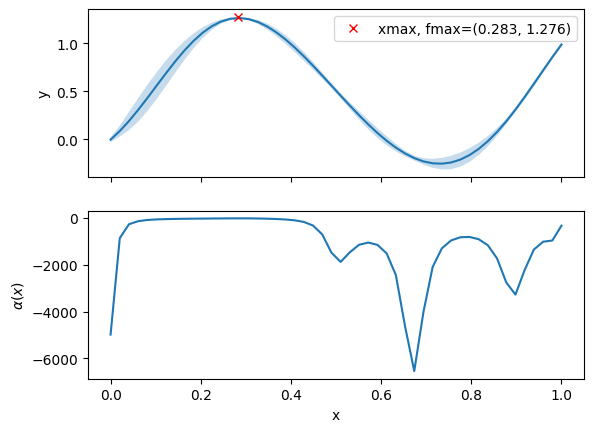

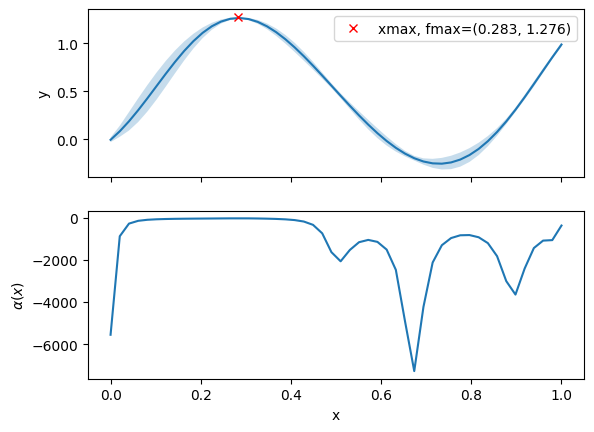

In [75]:
def f(x):
    return torch.sin(2*torch.pi*x) + x + torch.randn_like(x) * 0.01

train_x = torch.tensor([0.5],dtype=torch.double).unsqueeze(-1)
train_y = f(train_x)

niter = 20
bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)
for _ in range(niter):
  gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
    )
  mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
  fit_gpytorch_mll(mll)

  fmax = torch.max(train_y)
  xmax = train_x[torch.argmax(train_y)]
  acquisition_function = LogExpectedImprovement(gp, best_f=fmax)
  candidate, acq_value = optimize_acqf(
      acquisition_function, bounds, q=1,
      num_restarts=5, raw_samples=20)

  new_x = candidate
  new_y = f(candidate)

  train_x = torch.cat([train_x, new_x], dim=0)
  train_y = torch.cat([train_y, new_y], dim=0)


  plot_model_acq(gp, xmax, fmax)



In [76]:
train_x[train_y.argmax()], f(train_x[train_y.argmax()])

(tensor([0.2832], dtype=torch.float64), tensor([1.2566], dtype=torch.float64))

# Trust region BO

## **Task**
Rewrite the optimization loop above to set the acquisition function bounds centered at the location of the current optimum +/- 10\% of the input domain. Plot the objective function vs iteration for both cases. How does this affect optimization performance?

In [93]:
train_x = torch.tensor([0.5],dtype=torch.double).unsqueeze(-1)
train_y = f(train_x)

In [88]:
bounds.shape

torch.Size([2, 1])

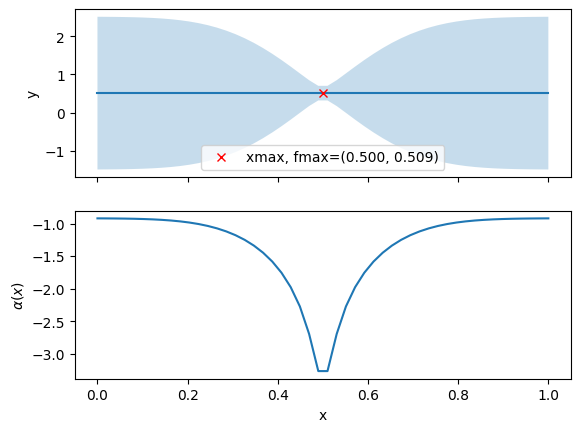

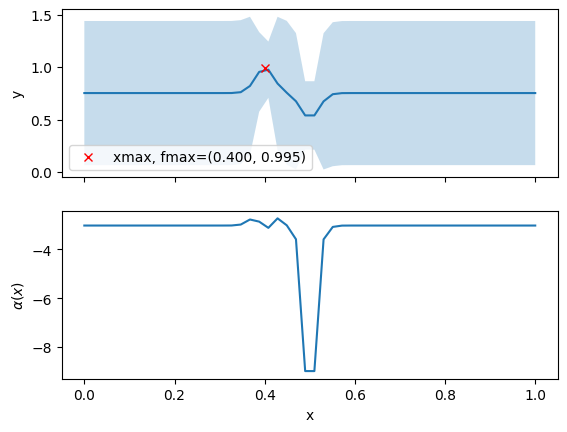

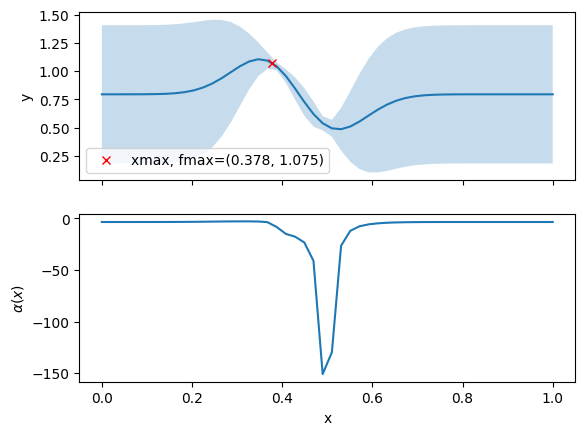

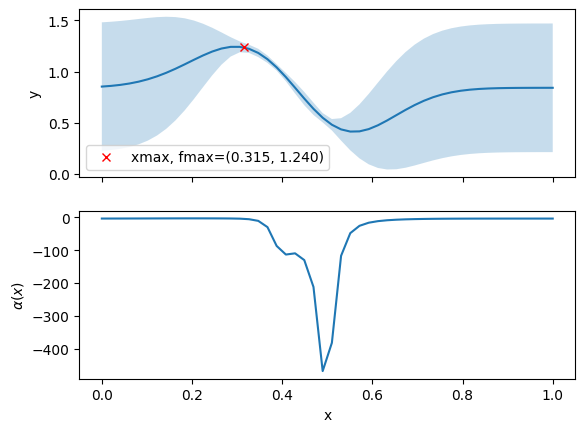

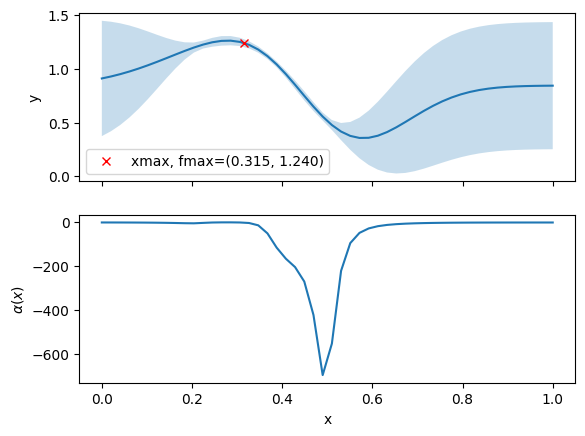

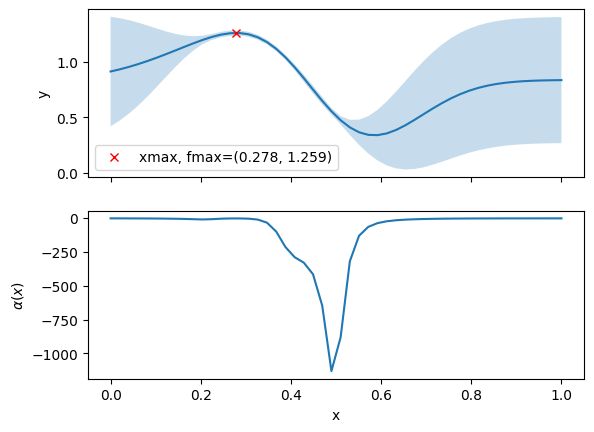

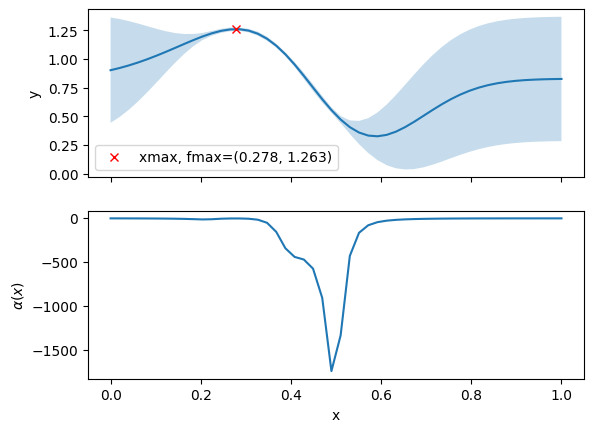

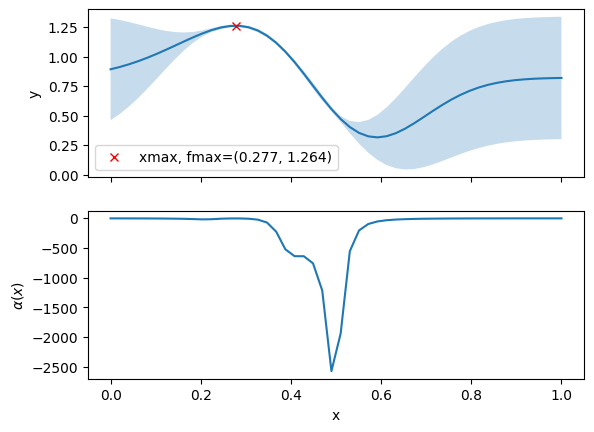

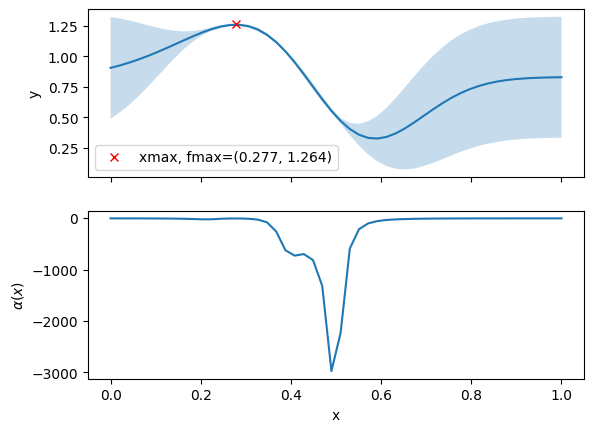

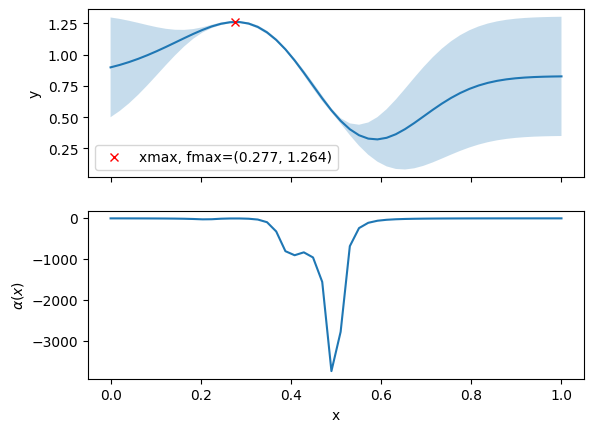

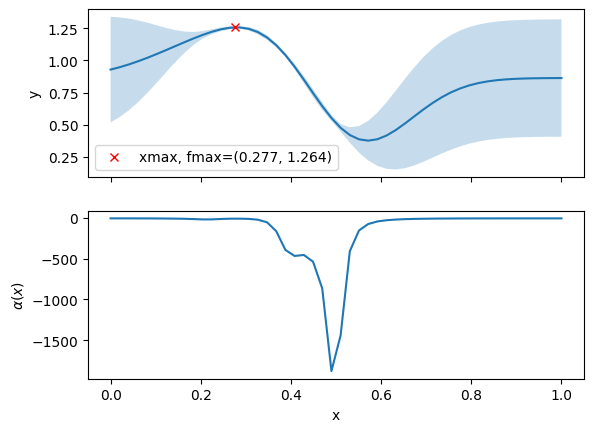

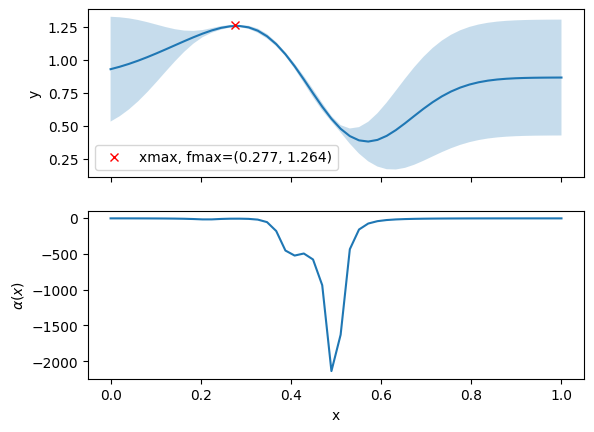

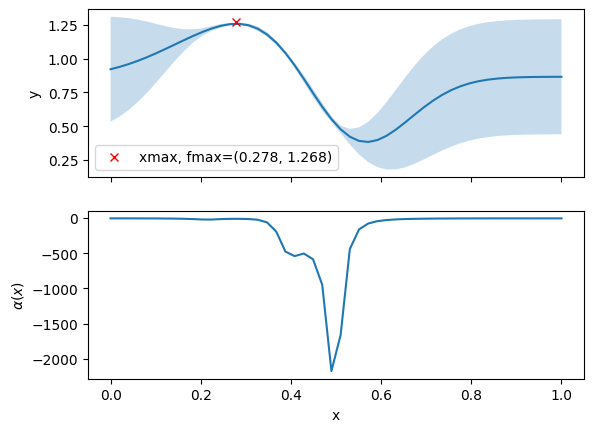

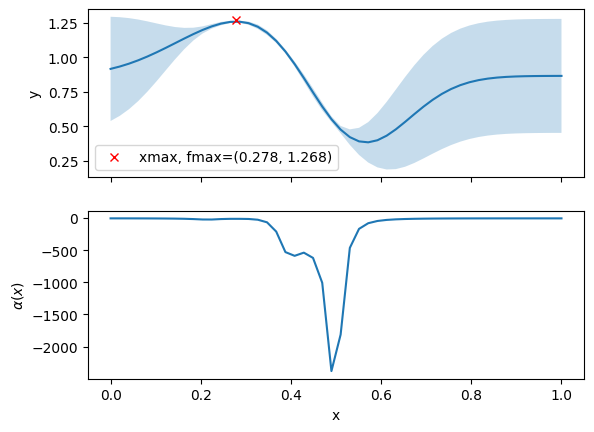

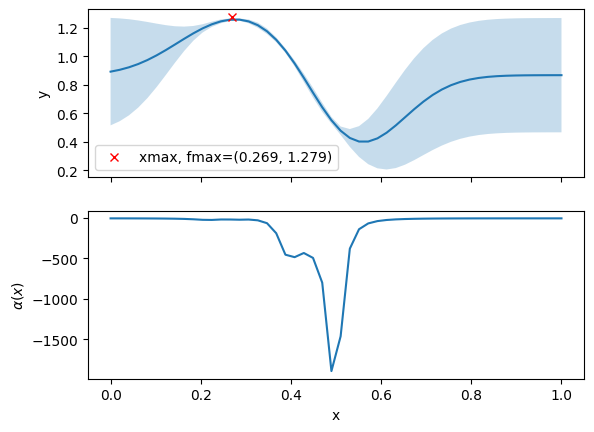

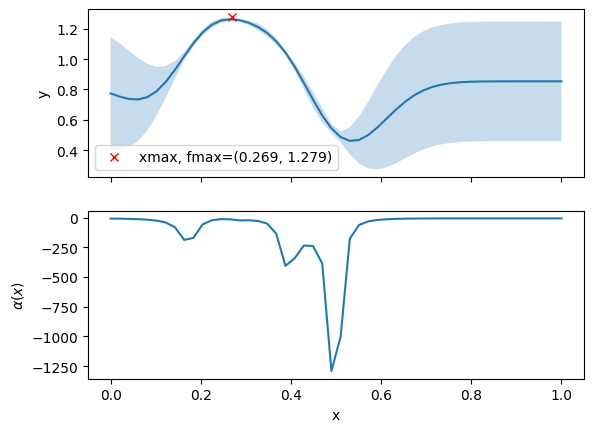

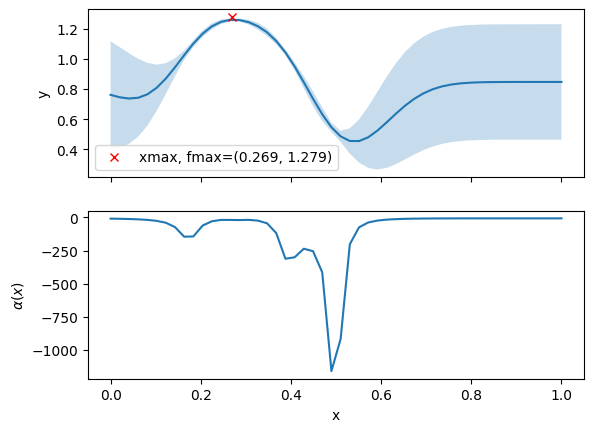

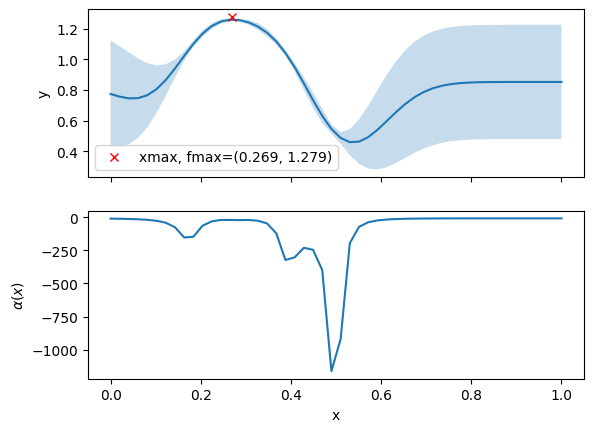

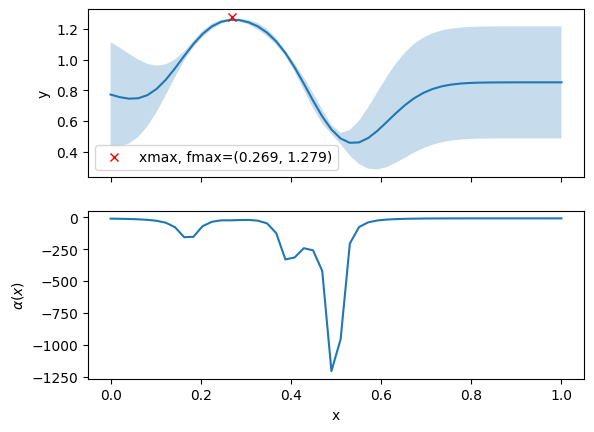

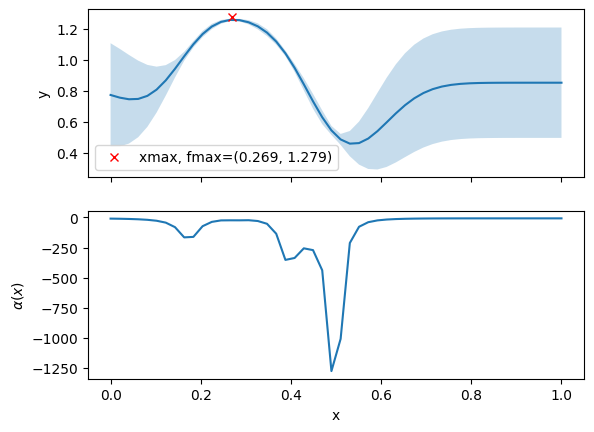

In [94]:
niter = 20
for _ in range(niter):
  gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
    )
  mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
  fit_gpytorch_mll(mll)
  fmax = torch.max(train_y)
  xmax = train_x[torch.argmax(train_y)]
  acquisition_function = LogExpectedImprovement(gp, best_f=fmax)
  l, u = xmax - 0.1, xmax + 0.1
  bounds = torch.stack([l*torch.ones(1), u*torch.ones(1)]).to(torch.double)
  bounds = torch.clip(bounds, 0, 1)
  candidate, acq_value = optimize_acqf(
      acquisition_function, bounds, q=1,
      num_restarts=5, raw_samples=20)

  new_x = candidate
  new_y = f(candidate)

  train_x = torch.cat([train_x, new_x], dim=0)
  train_y = torch.cat([train_y, new_y], dim=0)


  plot_model_acq(gp, xmax, fmax)



> **Your answer here** (How does this affect optimization performance?)

It seems to improve convergence speed. I ran some trials and in some of them, without the constraint, the solution could wander in the wrong direction before finally finding its way. In the 10% constrained bounds I have not observed this.

 # **Homework**
Minimize the beamsize function defined in lab 1, using Xopt's `ExpectedImprovementGenerator`, defined for you below. Note that you can call `X.random_evaluate()` to generate random samples for creating the initial GP model.
  See https://xopt.xopt.org/examples/single_objective_bayes_opt/bo_tutorial/ for
  an example.

In [149]:
from cheetah.particles import ParameterBeam
from cheetah.accelerator import Drift, Quadrupole, Segment

incoming_beam = ParameterBeam.from_twiss(
    beta_x=torch.tensor(5.0),
    alpha_x=torch.tensor(0.0),
    emittance_x=torch.tensor(1e-8)
)

beamline = Segment(
    [
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q1",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q2",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q3",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0))
    ]
)

def calculate_beamsize(K, noise = 1e-4):

    # set beamline parameters
    beamline.Q1.k1 = torch.tensor(K[0])
    beamline.Q2.k1 = torch.tensor(K[1])
    beamline.Q3.k1 = torch.tensor(K[2])

    # track the beam
    final_beam = beamline.track(incoming_beam)

    # return the beam size in x (in mm)
    return (final_beam.sigma_x**2 + final_beam.sigma_y**2).sqrt() * 1e3 + noise * torch.randn(1)


In [150]:
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import VOCS, Evaluator, Xopt
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt import VOCS

vocs = VOCS(
    variables={
        "k1": [0,15],
        "k2": [-15,0],
        "k3": [0, 15]
    },
    objectives={"beamsize": "MINIMIZE"}
)

def eval(input):
  K = list(input.values())
  return {"beamsize": calculate_beamsize(K).item()}

generator = ExpectedImprovementGenerator(vocs=vocs)
evaluator = Evaluator(function=eval)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [151]:
X.random_evaluate(5)
X.data


,k1,k2,k3,beamsize,xopt_runtime,xopt_error
0,0.488142,-2.725173,14.139634,0.069621,0.007246,False
1,12.230253,-14.586729,1.155578,0.824269,0.003801,False
2,13.839917,-8.697978,7.860587,0.520347,0.003873,False
3,9.772590,-11.749704,5.415303,0.373210,0.003260,False
4,14.224860,-7.832039,8.459368,0.494401,0.003541,False


In [152]:
n_steps = 20
for i in range(n_steps):
    # get the Gaussian process model from the generator
    # do the optimization step
    X.step()

In [153]:
X.data.tail()

,k1,k2,k3,beamsize,xopt_runtime,xopt_error
20,15.000000,-14.011779,15.000000,0.167543,0.004339,False
21,15.000000,0.000000,15.000000,0.082935,0.004723,False
22,7.487355,-15.000000,15.000000,0.070633,0.004335,False
23,2.867148,-15.000000,15.000000,0.028757,0.005716,False
24,15.000000,0.000000,13.326777,0.162944,0.004066,False


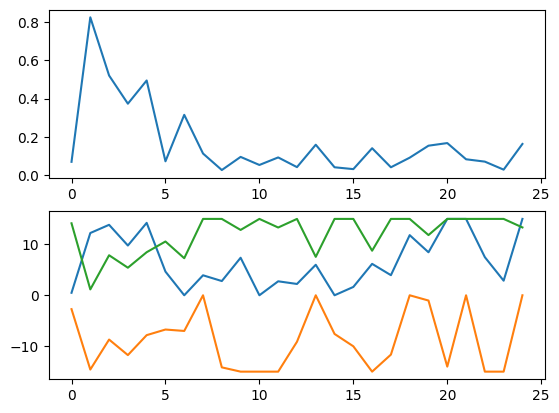

In [154]:
fig, axs = plt.subplots(2)
axs[0].plot(X.data["beamsize"])
axs[1].plot(X.data["k1"])
axs[1].plot(X.data["k2"])
axs[1].plot(X.data["k3"])
fig.show()

In [155]:
X.generator.get_optimum()

,k1,k2,k3
0,2.7557,-15.0,15.0


In [156]:
X.evaluate(X.generator.get_optimum().to_dict("records")[0])

{'beamsize': 0.028910480439662933,
 'xopt_runtime': 0.004090182002983056,
 'xopt_error': False}

# **BONUS Homework (NOT GRADED)**
Now solve the multi-objective 2-D ZDT problem from Lab 2 using Mulit-Objective Bayesian Optimization (MOBO) using the `MOBOGenerator` object in Xopt (see https://xopt.xopt.org/examples/multi_objective_bayes_opt/mobo/ for an example). Plot the front projected onto the bunch length vs. horizontal emittance subspace. Plot the acquisition function on the 2D input plane every 5 steps. Finally, calculate the hypervolume of the Pareto front at the end of the optimization run.

In [179]:
from xopt import Evaluator

# define the problem as a python callable
n_dims = 10
def evaluate(input_dict):
    x = np.array([input_dict[f"x{i + 1}"] for i in range(n_dims)])

    f1 = x[0]
    g = 1 + (9 / (n_dims - 1)) * np.sum(x[1:])
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h

    return {"f1": f1, "f2": f2, "g": g}

evaluator = Evaluator(function=evaluate)

## Define the variables and objectives
Next we define the variables and objectives for our problem in a `VOCS` object.

In [188]:
from xopt import VOCS
n_dims = 2
vocs = VOCS(
    variables={f"x{i + 1}": [0, 1] for i in range(n_dims)},
    objectives={"f1": "MINIMIZE", "f2": "MINIMIZE"},
)
vocs.model_dump()

{'variables': {'x1': [0.0, 1.0], 'x2': [0.0, 1.0]},
 'constraints': {},
 'objectives': {'f1': 'MINIMIZE', 'f2': 'MINIMIZE'},
 'constants': {},
 'observables': []}

## Define the optimization algorithm

In [189]:
from xopt.generators.bayesian import MOBOGenerator
generator = MOBOGenerator(
    vocs=vocs,
    reference_point={"f1":11, "f2": 11}
)
generator.model_dump()

{'model': None,
 'n_monte_carlo_samples': 128,
 'turbo_controller': None,
 'use_cuda': False,
 'gp_constructor': {'name': 'standard',
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'trainable_mean_keys': [],
  'transform_inputs': True,
  'custom_noise_prior': None,
  'use_cached_hyperparameters': False},
 'numerical_optimizer': {'name': 'LBFGS',
  'n_restarts': 20,
  'max_iter': 2000,
  'max_time': None},
 'max_travel_distances': None,
 'fixed_features': None,
 'computation_time': None,
 'custom_objective': None,
 'n_interpolate_points': None,
 'n_candidates': 1,
 'reference_point': {'f1': 11.0, 'f2': 11.0},
 'use_pf_as_initial_points': False}

## Combine the evaluator, vocs, and generator objects into the Xopt object

In [190]:
from xopt import Xopt
X = Xopt(
    vocs=vocs,
    generator=generator,
    evaluator=evaluator
)

In [191]:
X.random_evaluate(5)

,x1,x2,f1,f2,g,xopt_runtime,xopt_error
0,0.050756,0.187838,0.050756,2.321000,2.690542,0.000046,False
1,0.350436,0.402683,0.350436,3.351167,4.624143,0.000014,False
2,0.999543,0.083046,0.999543,0.425819,1.747415,0.000010,False
3,0.394593,0.840230,0.394593,6.723991,8.562069,0.000009,False
4,0.378055,0.199647,0.378055,1.768545,2.796821,0.000009,False


In [194]:
iterations = 40
for _ in range(iterations):
    X.step()

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local

<Axes: xlabel='f1', ylabel='f2'>

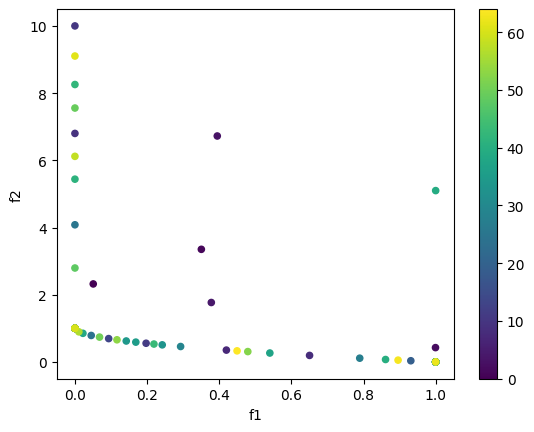

In [195]:
X.data.plot.scatter(x="f1",y="f2",c=X.data.index,cmap="viridis")